### `DBSCAN`

The DBSCAN algorithm views clusters as areas of high density separated by areas of low density. Due to this rather generic view, clusters found by DBSCAN can be any shape, as opposed to k-means which assumes that clusters are convex shaped. The central component to the DBSCAN is the concept of core samples, which are samples that are in areas of high density. **A cluster is therefore a set of core samples, each close to each other and a set of non-core samples that are close to a core sample**.

There are two parameters to the algorithm, `min_samples` and `eps`, which define formally what we mean when we say dense. Higher min_samples or lower eps indicate higher density necessary to form a cluster. More formally, **we define a core sample as being a sample in the dataset such that there exist min_samples other samples within a distance of eps, which are defined as neighbors of the core sample**.

While the parameter `min_samples` primarily controls how tolerant the algorithm is towards noise (on noisy and large data sets it may be desirable to increase this parameter), the parameter `eps` is crucial to choose appropriately for the data set and distance function and usually cannot be left at the default value. It controls the local neighborhood of the points. When chosen too small, most data will not be clustered at all (and labeled as -1 for “noise”). When chosen too large, it causes close clusters to be merged into one cluster, and eventually the entire data set to be returned as a single cluster. Some heuristics for choosing this parameter have been discussed in the literature, for example based on a knee in the nearest neighbor distances plot

#### **Example: Synthesis Dataset**

In [2]:
import sys
print(sys.version)

3.12.2 (tags/v3.12.2:6abddd9, Feb  6 2024, 21:26:36) [MSC v.1937 64 bit (AMD64)]


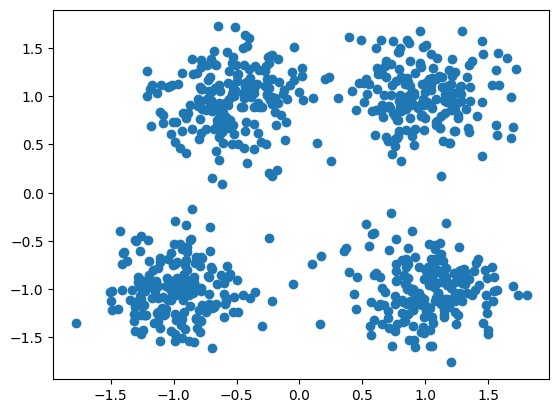

In [3]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

center = [[1,1], [-0.5,1], [-1,-1], [1,-1]]
X, labels_true = make_blobs(n_samples=750, centers=center, cluster_std =.3, random_state=0)

plt.scatter(X[:,0], X[:,1])
plt.show()

#### **Building a DBSCAN using** `scikit-learn`

We now have all of the pieces to make DBSCAN using scikit learn library.

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)
X_scaled

array([[ 0.81208923,  1.07796431],
       [-0.78801824,  0.82287879],
       [ 0.68248711,  0.77093815],
       ...,
       [ 0.35311843, -1.16258386],
       [-0.57269397,  1.47568592],
       [ 0.61978465, -1.1754205 ]])

We initialize sklearn.cluster.DBSCAN and fit the density-based clustering from features or distance matrix

In [5]:
from sklearn.cluster import DBSCAN

model = DBSCAN(eps=0.3,min_samples=13)
model.fit(X_scaled)

DBSCAN(eps=0.3, min_samples=13)

One can access the labels assigned by DBSCAN using the labels_ attribute.Noisy samples are given the label math: -1.

In [6]:
labels = model.labels_
n_cluster = len(set(labels))-(1 if -1 in labels else 0) # jumlah kluster terbentuk tanpa noise(-1 jika ada noise jika tidak -0)
n_noise = list(labels).count(-1) # jumlah data yang termasuk noise

# print(f'Jumlah labels {len(set(labels))}')
print(f'Estimated number of cluster {n_cluster}')
print(f'Estimated number of noise {n_noise}')

Estimated number of cluster 4
Estimated number of noise 14


In [7]:
import seaborn as sns

sns.scatterplot(x=X[:,0], y=X[:,1], hue=labels)
plt.title("DBSCAN Clustering with estimated number of clusters {n_cluster}")
plt.show()

# semakin besar epsilon atau semakin kecil n_sample maka semakin mudah sebuah cluster terbentuk

ModuleNotFoundError: No module named 'seaborn'

Core samples (large dots) and non-core samples (small dots) are color-coded according to assigned cluster. Samples tagged as noise are represented in black.

In [6]:
import numpy as np
import pandas as pd

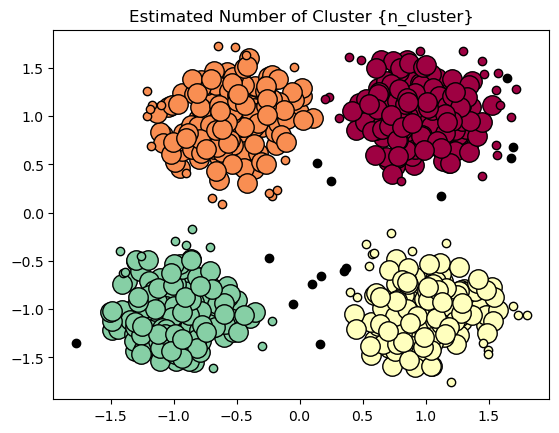

In [7]:
unique_labels = set(labels)
core_sample_mask = np.zeros_like(labels, dtype=bool)
core_sample_mask[model.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0,1,len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = 'k'
    
    class_member_mask = (labels == k)

    # core
    xy = X[class_member_mask & core_sample_mask]
    plt.plot(
        xy[:,0],
        xy[:,1],
        'o',
        markerfacecolor=col,
        markeredgecolor='k',
        markersize=14
    )

    # non-core (boundary/edge)
    xy = X[class_member_mask & ~core_sample_mask]
    plt.plot(
        xy[:,0],
        xy[:,1],
        'o',
        markerfacecolor=col,
        markeredgecolor='k',
        markersize=6
    )

plt.title('Estimated Number of Cluster {n_cluster}')
plt.show()

In [8]:
pd.Series(labels).value_counts()

 0    185
 1    185
 3    184
 2    182
-1     14
Name: count, dtype: int64

`Optimizing minimum samples and epsilon`

In [9]:
from sklearn.metrics import silhouette_score

epsilon = [0.2,0.3,0.4,0.5]
min_samples = [10,15,20,25]

epsilon_val = []
min_sample_val = []
scores = []
n_clusters = []
n_members = []

for eps in epsilon:
    for sample in min_samples:
        # define model
        model = DBSCAN(eps=eps, min_samples=sample)

        label = model.fit_predict(X_scaled)

        try:
            score = silhouette_score(X_scaled, label, random_state=0)
        except:
            score = None

        epsilon_val.append(eps)
        min_sample_val.append(sample)
        scores.append(score)
        n_clusters.append(list(np.unique(label)))
        n_members.append(list(np.bincount(label+1)))

In [10]:
pd.DataFrame({
    'Epsilon' : epsilon_val,
    'Min Sample' : min_sample_val,
    'Silhouette Score' : scores,
    'Cluster' : n_clusters,
    'Member' : n_members,
}).sort_values('Silhouette Score', ascending=False)

,Epsilon,Min Sample,Silhouette Score,Cluster,Member
5,0.3,15,0.652169,"[-1, 0, 1, 2, 3]","[16, 185, 183, 182, 184]"
6,0.3,20,0.644272,"[-1, 0, 1, 2, 3]","[24, 184, 181, 177, 184]"
7,0.3,25,0.643191,"[-1, 0, 1, 2, 3]","[35, 179, 180, 180, 176]"
0,0.2,10,0.619257,"[-1, 0, 1, 2, 3]","[56, 170, 175, 170, 179]"
15,0.5,25,0.586384,"[0, 1, 2]","[0, 376, 188, 186]"
1,0.2,15,0.561210,"[-1, 0, 1, 2, 3]","[100, 164, 155, 169, 162]"
4,0.3,10,0.512498,"[-1, 0, 1, 2]","[8, 374, 184, 184]"
2,0.2,20,0.487426,"[-1, 0, 1, 2, 3]","[148, 147, 141, 164, 150]"
11,0.4,25,0.440851,"[-1, 0, 1, 2]","[4, 375, 185, 186]"
10,0.4,20,0.432806,"[-1, 0, 1, 2]","[3, 375, 186, 186]"
